In [191]:
#X_train : label encoded
#X_train_1 : one hot encoded
#X_train_scale : Scaled data
#X_train_orig: original data without enocding 
#outlier_predict_train : SVM train result
#outlier_predict_test: SVM test result

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from numpy import array

In [193]:
#Get the dataset
df=pd.read_csv('nginx_IP_validation')

In [194]:
#Select only required features
ndf=df[['ip','response_code','url','access_method','user_name','user_agent_device','user_agent_os','user_agent_name','geoip_city_name','geoip_continent_name','geoip_country_iso_code','geoip_region_name','action']]

#preprocessing begins
#splitting ip into 4 segments
#ip=ndf['ip']
#ip_df=pd.DataFrame(ip)
#ip_df=ip_df['ip'].str.split('.',expand=True).rename(columns=lambda x: "segment"+str(x+1)).astype(int)
#ndf=ndf.join(ip_df)

#getting the first accessed route from url
url=ndf['url']
url_df=pd.DataFrame(url)
url_df=url_df['url'].str.split('/',expand=True)
url_df=url_df.loc[:,1].to_frame('url')
url_df=url_df.replace(r'^\s*$', np.nan, regex=True)
url_df.url.fillna('events',inplace=True)
url_df.rename(columns={'url':'access_route'},inplace=True)
ndf=ndf.join(url_df)

In [195]:
#Converting IP address to int values
ip_transform=[]
from ipaddress import ip_address
for i in df['ip']:
    ips=int(ip_address(i))
    ip_transform.append(ips)

ip_df=pd.DataFrame(ip_transform)
ip_df.rename(columns={0:'ip_transform'},inplace=True)
ndf=ndf.join(ip_df)

In [196]:
#Making allow as 1 and block as -1 and storing it into attack column
ndf.loc[ndf['action'] == "allow", "attack"] = 1  
ndf.loc[ndf['action'] != "allow", "attack"] = -1
target=ndf['attack']

In [197]:
#drop the processed columns
ndf.drop(columns=['ip','url','action'],inplace=True)

In [198]:
#estimate number of outliers in the dataset
nu = target[target == -1]  
print("nu.shape", nu.shape)  
print("outlier fraction", nu.shape[0]/target.shape[0])


nu.shape (234,)
outlier fraction 0.010852425563491327


In [199]:
normal=ndf.loc[ndf.attack==1] #dataframe with normal observations 
abnormal=ndf.loc[ndf.attack==-1] #dataframe with abnormal observations



In [200]:
# Once class SVM is trained with the observations of only one class.The algorithm is trained with 
# first 19000 observation of normal transactions. The remaining observation is merged with the anomalous observation 
# to create a test set. 
X_train = normal.loc[0:19000, :].drop('attack',1)

#creating test observations
X_test_1 = normal.loc[19001:, :].drop('attack',1)
X_test_2 = abnormal.drop('attack',1)
X_test = X_test_1.append(X_test_2)

#Y_test to test the output of model
Y_1 = normal.loc[19001:, 'attack']
Y_2 = abnormal['attack']
Y_test= Y_1.append(Y_2)

X_train_orig=X_train.copy()
X_test_orig=X_test.copy()



In [201]:
#X_train=pd.get_dummies(X_train)
#X_test = pd.get_dummies(X_test)
#X_test=X_test.reindex(columns = X_train.columns, fill_value=0)


In [202]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in X_test.columns.values:
    # Encoding only categorical variables
    if X_test[col].dtypes=='object':
    # Using whole data to form an exhaustive list of levels
        data=X_train[col].append(X_test[col])
        le.fit(data.values)
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])

In [203]:
#Then encoding using one hot encoding
from sklearn.preprocessing import OneHotEncoder
columns=['access_method','user_name','user_agent_device','user_agent_os','user_agent_name','geoip_city_name','geoip_continent_name','geoip_country_iso_code','geoip_region_name','access_route']
enc=OneHotEncoder(sparse=False)


X_train_1=X_train
X_test_1=X_test

for col in columns:
    data=X_train[[col]].append(X_test[[col]])
    enc.fit(data.values)
    
    temp = enc.transform(X_train[[col]])
    # Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])
    # Setting the index values similar to the X_train data frame
    temp=temp.set_index(X_train.index.values)
    # adding the new One Hot Encoded varibales to the train data frame
    X_train_1=pd.concat([X_train_1,temp],axis=1)
    
    # fitting One Hot Encoding on test data
    temp = enc.transform(X_test[[col]])
    # changing it into data frame and adding column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])
    # Setting the index for proper concatenation
    temp=temp.set_index(X_test.index.values)
    # adding the new One Hot Encoded varibales to test data frame
    X_test_1=pd.concat([X_test_1,temp],axis=1)

In [204]:
#Drop the initial columns that are already encoded
X_train_1.drop(columns=columns,axis=1,inplace=True)
X_test_1.drop(columns=columns,axis=1,inplace=True)

In [205]:
#standardadizing as SVM assumes standardization
from sklearn.preprocessing import scale
X_train_scale=scale(X_train_1)
X_test_scale=scale(X_test_1)

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [206]:
# Setting the hyperparameters for Once Class SVM
oneclass = svm.OneClassSVM(kernel='rbf', gamma=0.004, nu=0.0001)

In [207]:
#Fit the model with train_feature
oneclass.fit(X_train_scale)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.004, kernel='rbf',
      max_iter=-1, nu=0.0001, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [208]:
#Output of one class SVM
outlier_predict_test=oneclass.predict(X_test_scale)

In [209]:
# Check the number of outliers predicted by the algorithm
unique, counts = np.unique(outlier_predict_test, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  -1  362]
 [   1 2224]]


In [210]:
#Convert Y-test and outlier_predict to dataframe 

Y_test= Y_test.to_frame()
Y_test=Y_test.reset_index()
outlier_predict_test = pd.DataFrame(outlier_predict_test)
outlier_predict_test= outlier_predict_test.rename(columns={0: 'prediction'})

In [211]:
#Calculate false positives and negatives
TP = FN = FP = TN = 0
for j in range(len(Y_test)):
    if Y_test['attack'][j]== 1 and outlier_predict_test['prediction'][j] == 1:
        TP = TP+1
    elif Y_test['attack'][j]== 1 and outlier_predict_test['prediction'][j] == -1:
        FN = FN+1
    elif Y_test['attack'][j]== -1 and outlier_predict_test['prediction'][j] == 1:
        FP = FP+1
    else:
        TN = TN +1
print (TP,  FN,  FP,  TN)

2203 149 21 213


In [212]:
from sklearn import metrics
print("accuracy:",metrics.accuracy_score(Y_test['attack'],outlier_predict_test['prediction']))
print("precison:",metrics.precision_score(Y_test['attack'],outlier_predict_test['prediction']))
print("recall:",metrics.recall_score(Y_test['attack'],outlier_predict_test['prediction']))
print("f1:",metrics.f1_score(Y_test['attack'],outlier_predict_test['prediction']))
print("area under curve (auc): ", metrics.roc_auc_score(Y_test['attack'],outlier_predict_test['prediction'])) 

accuracy: 0.934261407579273
precison: 0.9905575539568345
recall: 0.9366496598639455
f1: 0.9628496503496503
area under curve (auc):  0.923453035060178


In [213]:
final_test_result_SVM=outlier_predict_test.set_index(X_test_orig.index.values).join(X_test_orig)

In [214]:
#Predict the train results
outlier_predict_train=oneclass.predict(X_train_scale)

In [215]:
#Convert train results to DataFrame
outlier_predict_train=pd.DataFrame(outlier_predict_train)
outlier_predict_train.rename(columns={0:'prediction'},inplace=True)

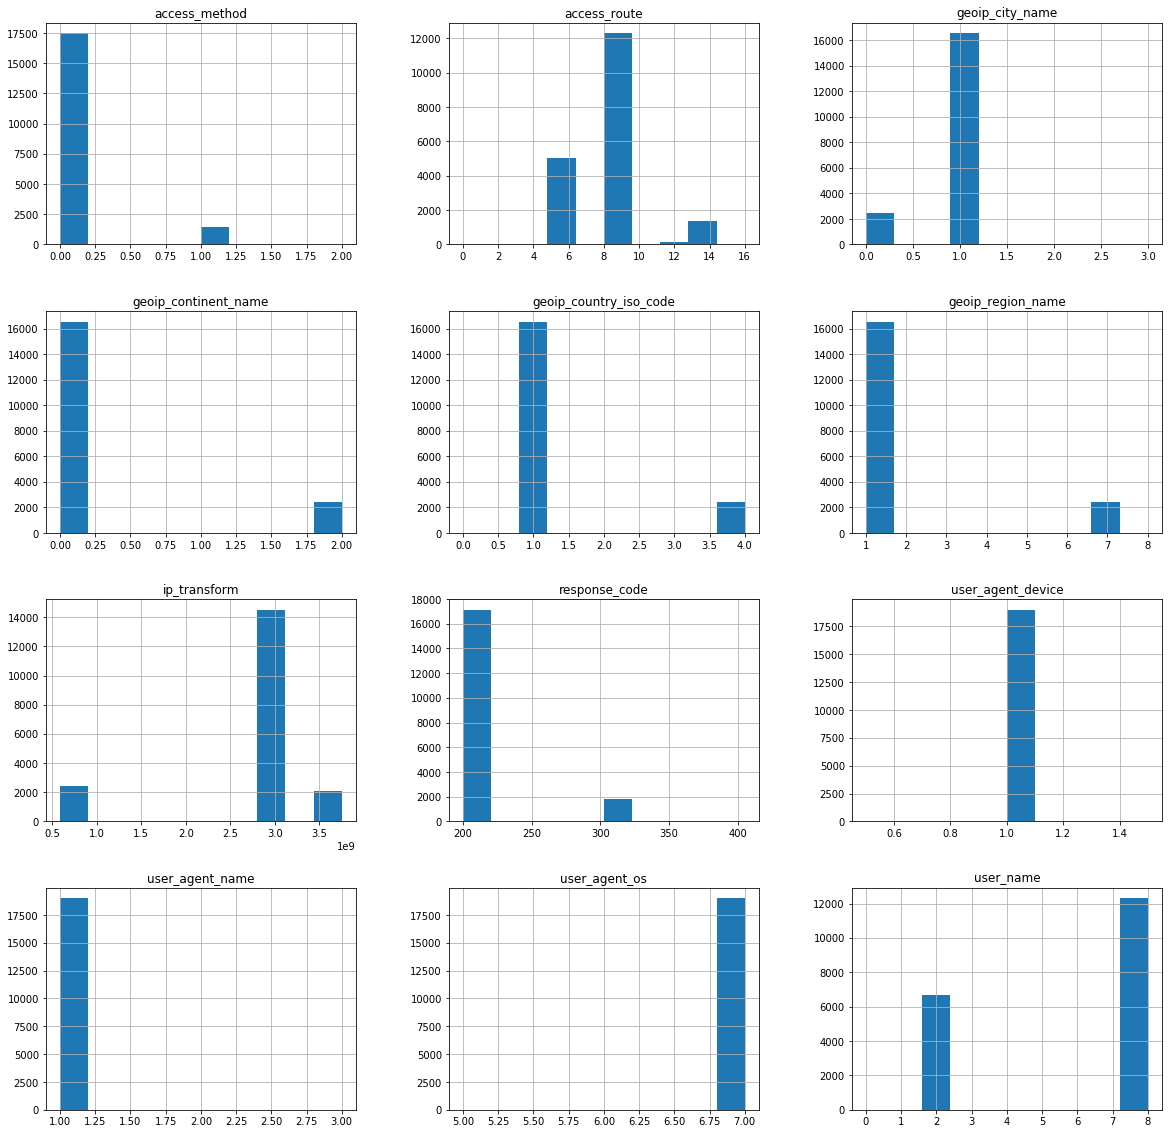

In [126]:
X_train.hist(figsize=(20,20))
plt.show()

In [127]:

corr=X_train.corr()

In [128]:
import seaborn as sns
fig=plt.figure(figsize=(12,9))

<Figure size 864x648 with 0 Axes>

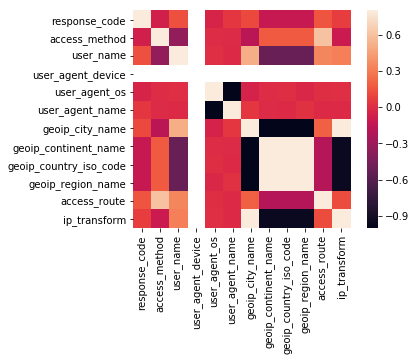

In [129]:
sns.heatmap(corr,vmax=0.8,square=True)
plt.show()

In [31]:
from sklearn.ensemble import IsolationForest
IsoForest=IsolationForest(n_estimators=80,contamination=0.01,max_samples=len(X_train))

IsoForest.fit(X_train)
y_predict_train=IsoForest.predict(X_train)
score_train=IsoForest.decision_function(X_train)

unique, counts = np.unique(y_predict_train, return_counts=True)
print (np.asarray((unique, counts)).T)

[[   -1   194]
 [    1 18782]]


In [33]:
y_predict_train=pd.DataFrame(y_predict_train)
y_predict_train.rename(columns={0:'prediction'},inplace=True)

In [34]:
y_predict_test=IsoForest.predict(X_test)
score_test=IsoForest.decision_function(X_test)

unique, counts = np.unique(y_predict_test, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  -1  392]
 [   1 2194]]


In [35]:
#convert y_predict_test to DataFrame
y_predict_test=pd.DataFrame(y_predict_test)
y_predict_test.rename(columns={0:'prediction'},inplace=True)

In [36]:
final_test_result_IF=y_predict_test.set_index(X_test.index.values).join(X_test_orig)

In [37]:
if (X_test.index.values.all()==final_test_result_IF.index.values.all()):
    print("hello")

hello


In [38]:
X_train_orig['score_IF']=score_train

In [39]:
X_train_orig['score_IF'][0]

0.03906412552275779

In [40]:
len(df[df['action']=='block'])

234

In [41]:
a=final_test_result_SVM[final_test_result_SVM['prediction']==-1]

In [42]:
b=final_test_result_IF[final_test_result_IF['prediction']==-1]

In [43]:
a.head()

,prediction,response_code,access_method,user_name,user_agent_device,user_agent_os,user_agent_name,geoip_city_name,geoip_continent_name,geoip_country_iso_code,geoip_region_name,access_route,ip_transform
19319,-1,200,POST,supritha,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,jenkinscore,2868415352
19342,-1,200,GET,supritha,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,jenkinscore,2868415352
19344,-1,200,GET,supritha,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,jenkinscore,2868415352
19345,-1,200,GET,supritha,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,jenkinscore,2868415352
19347,-1,200,GET,supritha,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,jenkinscore,2868415352


In [44]:
b.head()

,prediction,response_code,access_method,user_name,user_agent_device,user_agent_os,user_agent_name,geoip_city_name,geoip_continent_name,geoip_country_iso_code,geoip_region_name,access_route,ip_transform
19171,-1,200,GET,ethanadmin,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,rocketchat,2868415023
19337,-1,200,GET,ethanadmin,Other,Windows 10,Chrome,Bengaluru,Asia,IN,Karnataka,rocketchat,3753514638
20741,-1,200,GET,sushmitha,Other,Windows 10,Chrome,Ashburn,North America,US,Virginia,jenkinscore,583936030
20759,-1,200,GET,sushmitha,Other,Windows 10,Chrome,Ashburn,North America,US,Virginia,jenkinscore,583936030
20765,-1,200,GET,sushmitha,Other,Windows 10,Chrome,Ashburn,North America,US,Virginia,jenkinscore,583936030


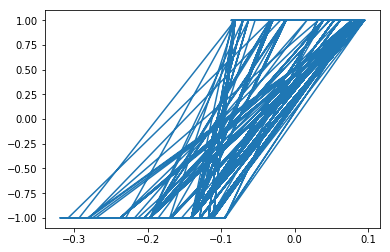

In [45]:
plt.plot(score_test,y_predict_test)
plt.show()

In [120]:
len(normal)

21328

In [121]:
len(df)

21562

In [137]:
256/21562

0.011872739078007606